In [2]:
!pip install tree
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics
from keras.models import model_from_json


from privacy.analysis.rdp_accountant import compute_rdp
from privacy.analysis.rdp_accountant import get_privacy_spent
from privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE



# Class definitons

In [16]:
class Data():
    
    
    
    def __init__(self,data):
        self.data=data
        
    def sample(self,start,end):
        size=len(self.data)
        return self.data[int(size*start):int(size*end)]
    
    def sample_smote(self,start,end):
        data=self.sample(start,end)
        dataSmote=np.array(data.drop("Class",axis=1))
        y=np.array(data[['Class']])
        smt=SMOTE()
        dataSmote,y=smt.fit_sample(dataSmote,y)
        dataSmote=pd.DataFrame(dataSmote)
        y=pd.DataFrame(y)
        dataSmote['Class']=y
        dataSmote=dataSmote.sample(frac=1)
        dataSmote.columns=list(data.columns)
        return dataSmote
        

In [17]:
class Aggregator():
    
    def __init__(self):
        self.wB1=0.55
        self.wB2=0.35
        self.wB3=0.10
    
    def aggregate(self,delta,B1,B2,B3):
        delta=np.array(delta)
        temp=(self.wB1*np.array(B1) + self.wB2*np.array(B2) + self.wB3*np.array(B3))
        temp-=delta
        delta+=temp
        
        return delta
    

In [18]:
class Model():
    
    def __init__(self):
        self.input_shape=(30,)
        self.model = tf.keras.Sequential([
              tf.keras.layers.Dense(64,input_shape=self.input_shape,activation='relu'),
              tf.keras.layers.Dense(32, activation='relu'),
              tf.keras.layers.Dense(16, activation='relu'),
              tf.keras.layers.Dense(8, activation='relu'),
              tf.keras.layers.Dense(4, activation='relu'),
              tf.keras.layers.Dense(1,activation='sigmoid')
            ])
        self.optimizer = DPGradientDescentGaussianOptimizer(
            l2_norm_clip=1.0,
            noise_multiplier=1.1,
            num_microbatches=100,
            learning_rate=0.15,
            unroll_microbatches=True)

        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
        
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=['accuracy'])
    
    def saveModel(self):
        model_json = self.model.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights("model.h5")
        print("Saved model to disk")
        
    def loadModel(self):
        json_file = open('model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
#         loaded_model = model_from_json(loaded_model_json)
#         # load weights into new model
#         loaded_model.load_weights("model.h5")
#         print("Loaded model from disk")
        
        loaded_model = tf.keras.models.model_from_json(loaded_model_json)
        
        loaded_model.load_weights("model.h5")

# model = keras.models.model_from_json(json)
# model.load_weights(weights_file_path)
        
        loaded_model.compile(optimizer=self.optimizer,loss=self.loss,metrics=['accuracy'])
        return loaded_model    
    

    def run(self,X,Y,validation_split=0.1,load=True):
        if(load):
            self.model=self.loadModel()
        #self.model.fit(X,Y,epochs=5,validation_split=validation_split,batch_size=1000,verbose=1)
        self.model.fit(X,Y,epochs=5,batch_size=self.batch_size,verbose=1)
        
    def evaluate(self,X,Y):
        x=self.model.predict(X)
        x=np.around(x)
        return np.sum(x==Y)/len(X)*100
    
    def loss(self,X,Y):
        return self.model.evaluate(X,Y)[0]
    
    def predict(self,X):
        return self.model.predict(X)
        
    
    def getWeights(self):
        return self.model.get_weights()
    
    def setWeights(self,weight):
        self.model.set_weights(weight)


In [19]:
class Bank(Model):
    
    def __init__(self,data,split_size=0):
        super().__init__()
        self.batch_list=[100,200,300,400,500,600,700,800,900,1000]
        self.data=data
        self.split(split_size)
    
    def setData(self,data,split_size=0):
        self.data=data
        self.split(split_size)
        
    def getData(self):
        return self.data
    
    def split(self,split_size):
        X=self.data.copy()
        X.drop(['Class'],axis=1,inplace=True)
        Y=self.data[['Class']]
        self.batch_size,train_size,test_size=self.getParams()
        self.X_train, self.X_test, self.Y_train, self.Y_test = X[:train_size],X[train_size:],Y[:train_size],Y[train_size:]
        #self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, test_size=split_size)
        
        
    def getParams(self):
        size=len(self.data)
        batch_size=min(self.batch_list, key=lambda x:abs(x-(size*0.02)))
        train_size=size - size%batch_size
        test_size=size%batch_size

        if(test_size<10):
            test_size+=batch_size
            train_size-=batch_size

        return batch_size,train_size,test_size

# EDA

In [7]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
data.shape

(284807, 31)

In [9]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))
data.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)

data.head()

data = data.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_data = data.loc[data['Class'] == 1]
non_fraud_data = data.loc[data['Class'] == 0]

normal_distributed_data = pd.concat([fraud_data, non_fraud_data])

# Shuffle dataframe rows
new_data = normal_distributed_data.sample(frac=1, random_state=42)

new_data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
7955,-0.084539,-0.866023,1.285888,-0.054289,0.413775,-0.066309,-0.176334,0.159908,-0.539002,-0.002637,...,-0.009153,-0.087286,-0.003036,-0.176694,-0.810982,0.344627,1.085001,-0.092363,-0.015434,0
282014,-0.282401,1.009258,2.122861,0.042675,-1.581932,0.198595,0.372053,-0.955055,0.300065,-0.409398,...,-0.170182,0.209250,0.815998,-0.095612,-0.594800,0.388289,-0.070571,-0.015149,-0.063839,0
139932,-0.279746,-0.014779,-3.951842,-2.829933,0.918408,1.451749,2.411681,-1.692281,-0.297503,-0.249471,...,-1.493438,-0.734317,-0.124367,2.126130,0.014251,0.250103,0.313907,0.354031,0.149120,0
139248,-0.027947,-0.018985,1.253428,0.233032,-0.189008,0.741237,0.340027,0.030813,0.110539,-0.014867,...,-0.063913,0.011772,0.015000,-0.269394,-0.824900,0.807229,-0.275086,0.005366,0.001045,0
273247,-0.279746,0.949389,2.060501,-0.131934,-1.084477,0.429631,-0.248828,-1.245778,0.108868,-0.271768,...,-0.296357,-0.301496,-0.789625,0.354650,0.015537,-0.337683,0.199131,-0.078106,-0.062229,0


In [10]:
#Using SMOTE

dataSmote=np.array(data.drop("Class",axis=1))
y=np.array(data[['Class']])
smt=SMOTE()
dataSmote,y=smt.fit_sample(dataSmote,y)
dataSmote=pd.DataFrame(dataSmote)
y=pd.DataFrame(y)
dataSmote['Class']=y
dataSmote=dataSmote.sample(frac=1)
dataSmote.columns=list(data.columns)

C:\Users\nomif\AppData\Local\Continuum\anaconda3\envs\Privacy\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Fraud Distribution SMOTE')

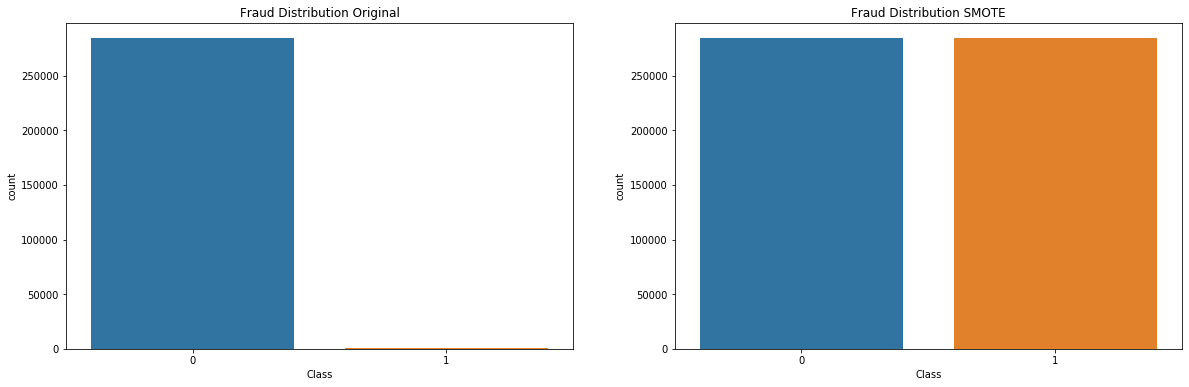

In [11]:
f, axes = plt.subplots(ncols=2, figsize=(20,6))

sb.countplot('Class',data=data,ax=axes[0])
axes[0].set_title('Fraud Distribution Original')

sb.countplot('Class',data=dataSmote,ax=axes[1])
axes[1].set_title('Fraud Distribution SMOTE')

# Federated Learning

In [20]:
results={}
aggregator=Aggregator()

In [21]:
datum=Data(data)

Data_Global=datum.sample_smote(0,0.1)              #use datum.sample  if smote not required
Data_Model_1A=datum.sample_smote(0.1,0.3)
Data_Model_2A=datum.sample_smote(0.3,0.45)
Data_Model_3A=datum.sample_smote(0.45,0.50)
Data_Model_1B=datum.sample_smote(0.50,0.70)
Data_Model_2B=datum.sample_smote(0.70,0.85)
Data_Model_3B=datum.sample_smote(0.85,0.90)
Data_Test=datum.sample_smote(0.90,1)

C:\Users\nomif\AppData\Local\Continuum\anaconda3\envs\Privacy\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nomif\AppData\Local\Continuum\anaconda3\envs\Privacy\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nomif\AppData\Local\Continuum\anaconda3\envs\Privacy\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nomif\AppData\Local\Continuum\anaconda3\envs\Privacy\lib\site-packages\sklearn\utils\

Text(0.5, 1.0, 'Data_Test')

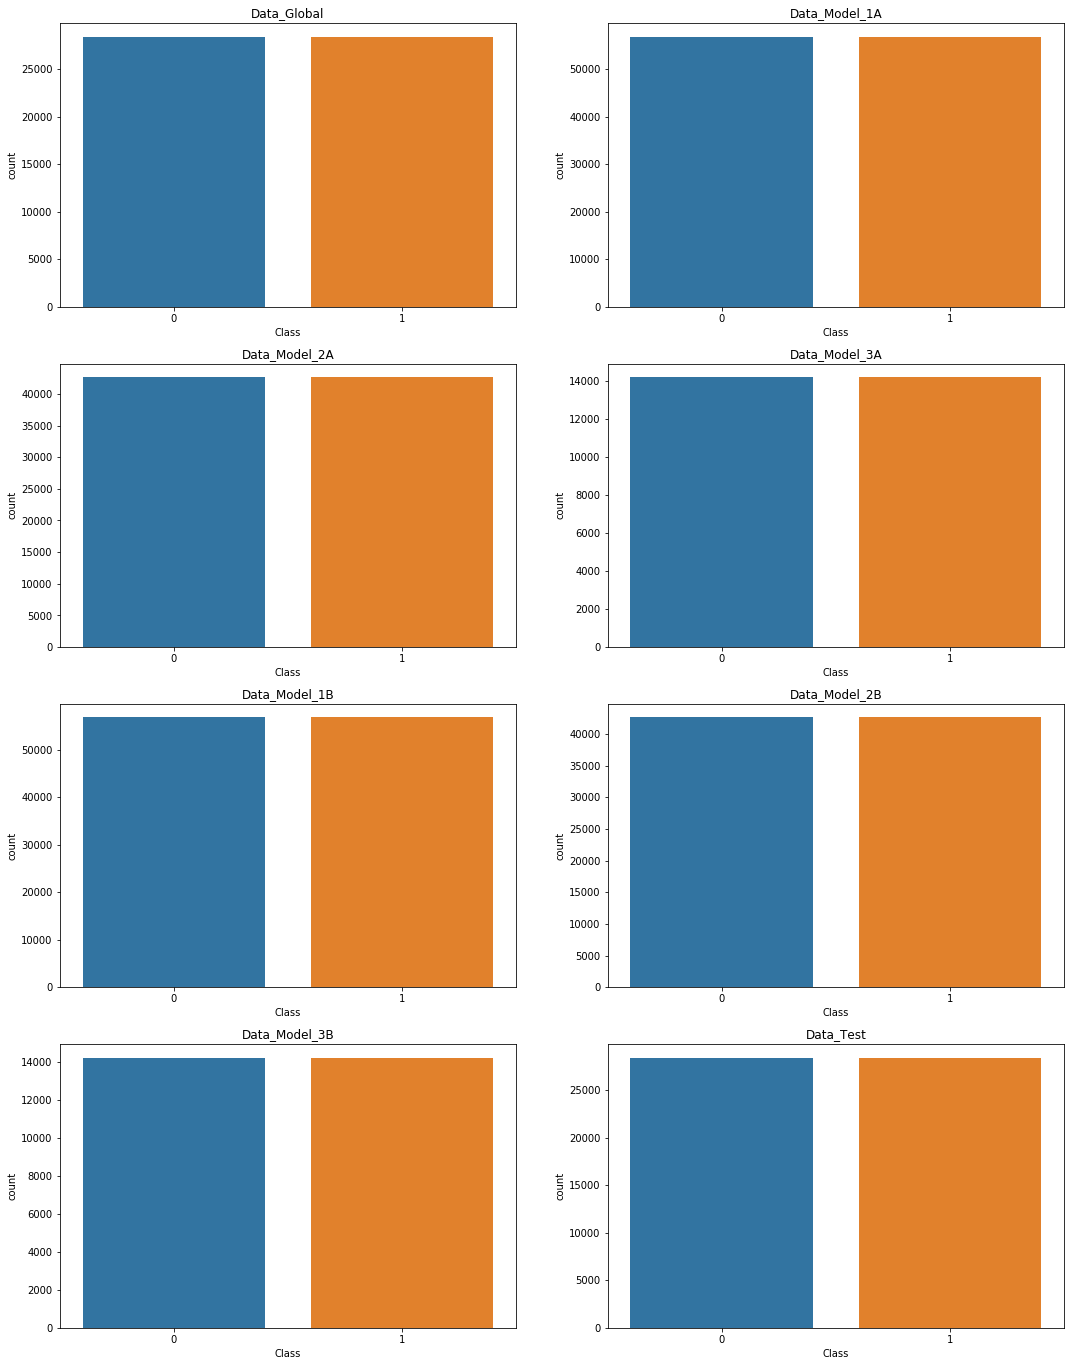

In [14]:
f, axes = plt.subplots(nrows=4,ncols=2,figsize=(18,24))

sb.countplot('Class',data=Data_Global,ax=axes[0,0])
axes[0,0].set_title('Data_Global')

sb.countplot('Class',data=Data_Model_1A,ax=axes[0,1])
axes[0,1].set_title('Data_Model_1A')



sb.countplot('Class',data=Data_Model_2A,ax=axes[1,0])
axes[1,0].set_title('Data_Model_2A')

sb.countplot('Class',data=Data_Model_3A,ax=axes[1,1])
axes[1,1].set_title('Data_Model_3A')



sb.countplot('Class',data=Data_Model_1B,ax=axes[2,0])
axes[2,0].set_title('Data_Model_1B')

sb.countplot('Class',data=Data_Model_2B,ax=axes[2,1])
axes[2,1].set_title('Data_Model_2B')


sb.countplot('Class',data=Data_Model_3B,ax=axes[3,0])
axes[3,0].set_title('Data_Model_3B')

sb.countplot('Class',data=Data_Test,ax=axes[3,1])
axes[3,1].set_title('Data_Test')




In [22]:
GlobalBank=Bank(Data_Global,0.0)
GlobalBank.run(GlobalBank.X_train, GlobalBank.Y_train,load=False)

results['BankG.1']=GlobalBank.evaluate(GlobalBank.X_test,GlobalBank.Y_test)

GlobalBank.saveModel()


Epoch 1/5
56000/56000 [==============================] - 13s 240us/sample - loss: 0.6665 - acc: 0.8101
Epoch 2/5
56000/56000 [==============================] - 6s 106us/sample - loss: 0.6013 - acc: 0.9291
Epoch 3/5
56000/56000 [==============================] - 6s 107us/sample - loss: 0.5578 - acc: 0.9269
Epoch 4/5
56000/56000 [==============================] - 6s 106us/sample - loss: 0.5386 - acc: 0.9300
Epoch 5/5
56000/56000 [==============================] - 6s 106us/sample - loss: 0.5324 - acc: 0.9332
Saved model to disk


In [23]:
Bank1=Bank(Data_Model_1A,0.2)
Bank1.run(Bank1.X_train,Bank1.Y_train)

Bank2=Bank(Data_Model_2A,0.2)
Bank2.run(Bank2.X_train,Bank2.Y_train)

Bank3=Bank(Data_Model_3A,0.2)
Bank3.run(Bank3.X_train,Bank3.Y_train)

delta=aggregator.aggregate(GlobalBank.getWeights(),Bank1.getWeights(),Bank2.getWeights(),Bank3.getWeights())

GlobalBank.setWeights(delta)
GlobalBank.saveModel()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/5
113000/113000 [==============================] - 19s 168us/sample - loss: 0.5290 - acc: 0.9424
Epoch 2/5
113000/113000 [==============================] - 12s 107us/sample - loss: 0.5222 - acc: 0.9572
Epoch 3/5
113000/113000 [==============================] - 12s 106us/sample - loss: 0.5189 - acc: 0.9639
Epoch 4/5
113000/113000 [==============================] - 12s 107us/sample - loss: 0.5177 - acc: 0.9666
Epoch 5/5
113000/113000 [==============================] - 12s 109us/sample - loss: 0.5167 - acc: 0.9680
Epoch 1/5
85000/85000 [==============================] - 16s 194us/sample - loss: 0.5485 - acc: 0.8891
Epoch 2/5
85000/85000 [==============================] - 9s 107us/sample - loss: 0.5407 - acc: 0.9098
Epoch 3/5
85000/85000 [===========

In [24]:
results['Bank1.1']=Bank1.evaluate(Bank1.X_test,Bank1.Y_test)
results['Bank2.1']=Bank2.evaluate(Bank2.X_test,Bank2.Y_test)
results['Bank3.1']=Bank3.evaluate(Bank3.X_test,Bank3.Y_test)
results['BankG.2']=GlobalBank.evaluate(GlobalBank.X_test,GlobalBank.Y_test)

In [25]:

Bank1.setData(Data_Model_1B,0.2)
Bank1.run(Bank1.X_train,Bank1.Y_train)

Bank2.setData(Data_Model_2B,0.2)
Bank2.run(Bank2.X_train,Bank2.Y_train)

Bank3.setData(Data_Model_3B,0.2)
Bank3.run(Bank3.X_train,Bank3.Y_train)



delta=aggregator.aggregate(GlobalBank.getWeights(),Bank1.getWeights(),Bank2.getWeights(),Bank3.getWeights())

GlobalBank.setWeights(delta)
GlobalBank.saveModel()

Epoch 1/5
113000/113000 [==============================] - 21s 190us/sample - loss: 0.5172 - acc: 0.9659
Epoch 2/5
113000/113000 [==============================] - 12s 109us/sample - loss: 0.5154 - acc: 0.9702
Epoch 3/5
113000/113000 [==============================] - 12s 110us/sample - loss: 0.5145 - acc: 0.9722
Epoch 4/5
113000/113000 [==============================] - 13s 114us/sample - loss: 0.5138 - acc: 0.9740
Epoch 5/5
113000/113000 [==============================] - 12s 109us/sample - loss: 0.5131 - acc: 0.9755
Epoch 1/5
85000/85000 [==============================] - 19s 221us/sample - loss: 0.5142 - acc: 0.9777
Epoch 2/5
85000/85000 [==============================] - 9s 110us/sample - loss: 0.5104 - acc: 0.9876
Epoch 3/5
85000/85000 [==============================] - 9s 110us/sample - loss: 0.5084 - acc: 0.9913
Epoch 4/5
85000/85000 [==============================] - 9s 108us/sample - loss: 0.5066 - acc: 0.9965
Epoch 5/5
85000/85000 [==============================] - 9s 109us/

In [26]:
results['Bank1.2']=Bank1.evaluate(Bank1.X_test,Bank1.Y_test)
results['Bank2.2']=Bank2.evaluate(Bank2.X_test,Bank2.Y_test)
results['Bank3.2']=Bank3.evaluate(Bank3.X_test,Bank3.Y_test)


In [27]:
GlobalBank.setData(Data_Test,0.9)
results['BankG.3']=GlobalBank.evaluate(GlobalBank.X_test,GlobalBank.Y_test)

In [36]:
for i in results.values():
    print(i)

Class    94.022989
dtype: float64
Class    96.207865
dtype: float64
Class    96.363636
dtype: float64
Class    99.52381
dtype: float64
Class    95.517241
dtype: float64
Class    98.873239
dtype: float64
Class    99.657534
dtype: float64
Class    99.568966
dtype: float64
Class    92.21968
dtype: float64
